### Fully Convolutional Networks training notebook

Before using this notebook, you must  download the datasets and prepare them using the provided scripts. Make sure that you have also downloaded VGG16 pre-trained weights using `vgg16_downloader.py` or by going to [Davi Frossard's website](http://www.cs.toronto.edu/~frossard/post/vgg16/). Note that these pre-trained weights expect input images in RGB format.

In [1]:
import importlib, sys, os.path
import itertools
import multiprocessing
import tensorflow as tf
from tensorflow.python.keras import backend as K
from distutils.version import LooseVersion

import fcn_model, fcn_run_loop


def reload_libs():
    """Utility function to reload libraries after making modifications to the code."""
    importlib.reload(sys.modules['fcn_model'])
    importlib.reload(sys.modules['fcn_run_loop'])


%matplotlib inline
# This model has been tested with TF1.12. Using at least version 1.8 is only a suggestion.
assert LooseVersion(tf.__version__) >= LooseVersion('1.8'), 'Please use TensorFlow version 1.8 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow version {}'.format(tf.__version__))
print('Keras version      {}'.format(tf.keras.__version__))
assert K.image_data_format() == 'channels_last'
assert K.floatx() == 'float32'

C:\Users\Florent\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version 1.12.0
Keras version      2.1.6-tf


Are you interested in a black theme for Jupyter notebooks? If yes, then copy the `dask_theme.css` to your .jupyter configuration directory and replace the path(s) below with your own location(s).

In [2]:
# Load a custom CSS for this notebook
from IPython.display import HTML

# Add a css file location for each of your working platforms
css_filenames = ['c:/users/asus-ux510/.jupyter/dark_theme.css', 
                 'c:/users/florent/.jupyter/dark_theme.css', 
                 'd:/userfiles/fmahoudeau/documents/.jupyter/dark_theme.css',
                 '/home/flo/.jupyter/dark_theme.css']

css = None
for css_filename in css_filenames:
    if os.path.isfile(css_filename):
        css = '<style>{}</style>'.format(open(css_filename).read())

HTML(css)

### Configuration

Set the `HOME_PATH`, `DATA_ROOT_PATH`, and select the `DATASET` to use for training.

In [3]:
if os.path.isdir('C:/Users/fmahoudeau/'):
    HOME_PATH = 'C:/Users/fmahoudeau/PycharmProjects/'
    DATA_ROOT_PATH = 'C:/Users/fmahoudeau/Datasets/'
elif os.path.isdir('C:/Users/Florent/'):
    HOME_PATH = 'C:/Users/Florent/'
    DATA_ROOT_PATH = 'G:/Datasets/'
else:
    assert False, 'Cannot resolve home directory'

DATASET = 'pascal_voc_2012'
assert DATASET in ('kitty_road', 'cam_vid', 'pascal_voc_2012', 'pascal_plus'), 'Unknown dataset'
VGG16_WEIGHTS_PATH = os.path.join(DATA_ROOT_PATH, 'vgg16/vgg16_weights.npz')

SAVED_MODELS_PATH = os.path.join(DATA_ROOT_PATH, 'trained_models/tensorflow/', DATASET)
if not os.path.exists(SAVED_MODELS_PATH):
    os.makedirs(SAVED_MODELS_PATH)

AUGMENTATION_PARAMS = {'saturation_range': (-20, 20), 'value_range': (-20, 20),
                       'brightness_range': None, 'contrast_range': None, 'blur_params': None,
                       'flip_lr': True, 'rotation_range': (-10, 10), 'shift_range': (32, 32),
                       'zoom_range': (0.5, 2.0), 'ignore_label': 21}

if DATASET == 'kitty_road':
    DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'data_road/')
    N_EPOCHS = 40
    BATCH_SIZE = 16
    OPTIMIZER = 'adam'
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.0
    EXP_DECAY = 0.0
    AUGMENTATION_PARAMS['rotation_range'] = (-5, 5)
    AUGMENTATION_PARAMS['ignore_label'] = 2
elif DATASET == 'cam_vid':
    DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'cam_vid/')
    N_EPOCHS = 80
    BATCH_SIZE = 16
    OPTIMIZER = 'adam'
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.0
    EXP_DECAY = 0.0
    AUGMENTATION_PARAMS['rotation_range'] = (-5, 5)
    AUGMENTATION_PARAMS['ignore_label'] = 11
elif DATASET == 'pascal_voc_2012':
    DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'pascal_voc_data/VOCdevkit/VOC2012/')
    N_EPOCHS = 100
    BATCH_SIZE = 12
    OPTIMIZER = 'adam'
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 1e-6
    EXP_DECAY = 0.0
else:
    DATASET_PATH = os.path.join(DATA_ROOT_PATH, 'pascal_plus_data/prepared/')
    N_EPOCHS = 30
    BATCH_SIZE = 12
    OPTIMIZER = 'adam'
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 1e-6
    EXP_DECAY = 0.0

PREDICTIONS_PATH = os.path.join(DATASET_PATH, 'predictions/')
if not os.path.exists(PREDICTIONS_PATH):
    os.makedirs(PREDICTIONS_PATH)

FLAGS = multiprocessing.Manager().Namespace()
fcn_run_loop.FLAGS = FLAGS

FLAGS.save_dir = SAVED_MODELS_PATH
FLAGS.vgg16_weights_path = VGG16_WEIGHTS_PATH
FLAGS.augmentation_params = AUGMENTATION_PARAMS
FLAGS.n_epochs = N_EPOCHS
FLAGS.batch_size = BATCH_SIZE
FLAGS.optimizer = OPTIMIZER
FLAGS.learning_rate = LEARNING_RATE
FLAGS.weight_decay = WEIGHT_DECAY
FLAGS.exp_decay = EXP_DECAY
FLAGS.dropout_rate = 0.5
FLAGS.debug = True

### PASCAL Plus

PASCAL Plus refers to the PASCAL VOC 2012 dataset augmented with the annotations from [Hariharan et al](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/).

<b>FCN32 Training</b><br>
<b>Note:</b> as expected, adding more data (compared to PASCAL VOC 2012) yields better results.

One-off FCN32 end-to-end training using pascal_plus
Building FCN32 for end-to-end training...
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-10T11:10:15.603051
Epoch 1/25, LR=9.999999747378752e-06
loss = 0.702, acc = 0.793, mean_acc = 0.648, mean_iou = 0.380, val_loss = 0.366, val_acc = 0.879, val_mean_acc = 0.619, val_mean_iou = 0.506
2019-02-10T11:25:18.488311

Epoch 2/25, LR=9.999999747378752e-06
loss = 0.485, acc = 0.839, mean_acc = 0.773, mean_iou = 0.505, val_loss = 0.352, val_acc = 0.886, val_mean_acc = 0.663, val_mean_iou = 0.537
2019-02-10T11:40:34.766489

Epoch 3/25, LR=9.999999747378752e-06
loss = 0.443, acc = 0.851, mean_acc = 0.805, mean_iou = 0.538, val_loss = 0.308, val_acc = 0.900, val_mean_acc = 0.713, val_mean_iou = 0.593
2019-02-10T11:55:39.288629

Epoch 4/25, LR=9.999999747378752e-06
loss = 0.400, acc = 0.863, mean_acc = 0.832, mean_iou = 0.574, val_loss = 0.299, v

<Figure size 432x288 with 0 Axes>

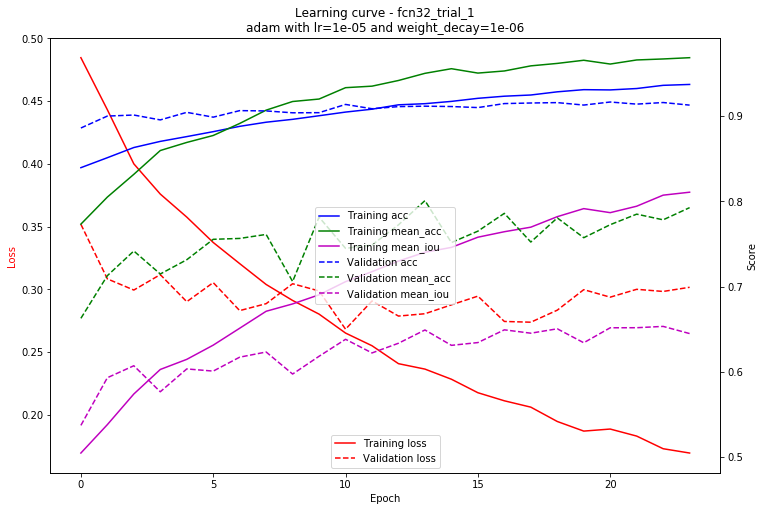

In [8]:
model, datasets = fcn_run_loop.oneoff_training('FCN32', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn32_trial_1')

<b>One-off FCN16 training</b><br>
<b>Note:</b> FCN16 performs better than FCN32 but training may not have totally converged below.

One-off FCN16 end-to-end training using pascal_plus
Building FCN16 for end-to-end training...
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-10T19:01:26.084261
Epoch 1/30, LR=9.999999747378752e-06
loss = 0.661, acc = 0.801, mean_acc = 0.668, mean_iou = 0.393, val_loss = 0.355, val_acc = 0.884, val_mean_acc = 0.718, val_mean_iou = 0.546
2019-02-10T19:16:19.877483

Epoch 2/30, LR=9.999999747378752e-06
loss = 0.469, acc = 0.845, mean_acc = 0.784, mean_iou = 0.512, val_loss = 0.319, val_acc = 0.895, val_mean_acc = 0.740, val_mean_iou = 0.578
2019-02-10T19:31:11.224487

Epoch 3/30, LR=9.999999747378752e-06
loss = 0.424, acc = 0.859, mean_acc = 0.821, mean_iou = 0.554, val_loss = 0.294, val_acc = 0.904, val_mean_acc = 0.733, val_mean_iou = 0.604
2019-02-10T19:45:57.073581

Epoch 4/30, LR=9.999999747378752e-06
loss = 0.395, acc = 0.866, mean_acc = 0.837, mean_iou = 0.577, val_loss = 0.315, v

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

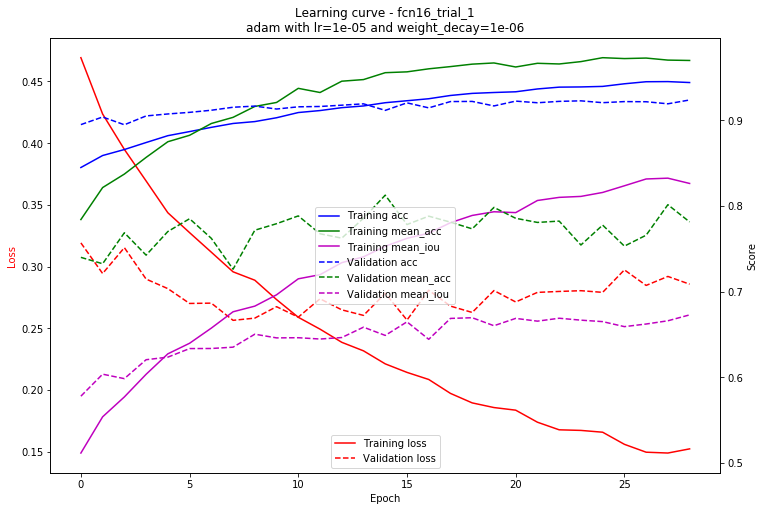

In [5]:
FLAGS.n_epochs = 30
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_1')

<b>One-off FCN8 training</b><br>
<b>Note:</b> FCN8 converged and performs slightly better than FCN16.

One-off FCN8 end-to-end training using pascal_plus
Building FCN8 for end-to-end training...
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-14T08:56:53.822180
Epoch 1/50, LR=9.999999747378752e-06
loss = 0.682, acc = 0.797, mean_acc = 0.658, mean_iou = 0.379, val_loss = 0.348, val_acc = 0.887, val_mean_acc = 0.667, val_mean_iou = 0.546
2019-02-14T09:11:51.322670

Epoch 2/50, LR=9.999999747378752e-06
loss = 0.489, acc = 0.841, mean_acc = 0.771, mean_iou = 0.498, val_loss = 0.329, val_acc = 0.892, val_mean_acc = 0.697, val_mean_iou = 0.563
2019-02-14T09:27:05.966310

Epoch 3/50, LR=9.999999747378752e-06
loss = 0.446, acc = 0.852, mean_acc = 0.802, mean_iou = 0.535, val_loss = 0.313, val_acc = 0.897, val_mean_acc = 0.769, val_mean_iou = 0.600
2019-02-14T09:42:02.169971

Epoch 4/50, LR=9.999999747378752e-06
loss = 0.412, acc = 0.861, mean_acc = 0.829, mean_iou = 0.562, val_loss = 0.310, val

2019-02-14T18:36:48.090849
Saving model checkpoint

Epoch 38/50, LR=9.999999747378752e-06
loss = 0.130, acc = 0.952, mean_acc = 0.977, mean_iou = 0.853, val_loss = 0.295, val_acc = 0.924, val_mean_acc = 0.788, val_mean_iou = 0.675
2019-02-14T18:53:05.480628
Saving model checkpoint

Epoch 39/50, LR=9.999999747378752e-06
loss = 0.128, acc = 0.953, mean_acc = 0.976, mean_iou = 0.854, val_loss = 0.309, val_acc = 0.924, val_mean_acc = 0.763, val_mean_iou = 0.668
2019-02-14T19:09:25.384330
Saving model checkpoint

Epoch 40/50, LR=9.999999747378752e-06
loss = 0.129, acc = 0.952, mean_acc = 0.976, mean_iou = 0.855, val_loss = 0.310, val_acc = 0.924, val_mean_acc = 0.775, val_mean_iou = 0.672
2019-02-14T19:25:47.510330

Epoch 41/50, LR=9.999999747378752e-06
loss = 0.123, acc = 0.954, mean_acc = 0.981, mean_iou = 0.861, val_loss = 0.281, val_acc = 0.927, val_mean_acc = 0.791, val_mean_iou = 0.686
2019-02-14T19:42:04.264559
Saving model checkpoint

Epoch 42/50, LR=9.999999747378752e-06
loss = 0.1

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

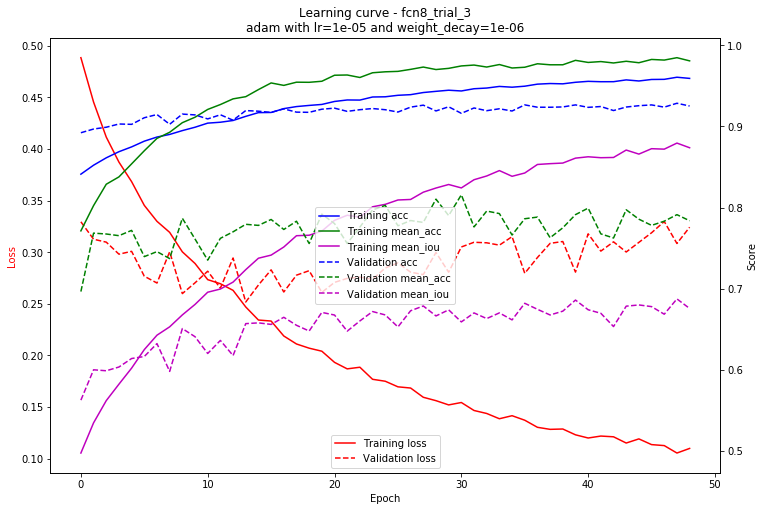

In [6]:
FLAGS.n_epochs = 50
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_3')

Training a little bit more until convergence.

2019-02-14T22:43:16.211400
Epoch 51/60, LR=9.999999747378752e-06
loss = 0.109, acc = 0.959, mean_acc = 0.979, mean_iou = 0.875, val_loss = 0.315, val_acc = 0.927, val_mean_acc = 0.793, val_mean_iou = 0.682
2019-02-14T23:00:10.570585
Saving model checkpoint

Epoch 52/60, LR=9.999999747378752e-06
loss = 0.107, acc = 0.960, mean_acc = 0.981, mean_iou = 0.877, val_loss = 0.296, val_acc = 0.926, val_mean_acc = 0.798, val_mean_iou = 0.685
2019-02-14T23:17:07.247029
Saving model checkpoint

Epoch 53/60, LR=9.999999747378752e-06
loss = 0.104, acc = 0.961, mean_acc = 0.982, mean_iou = 0.880, val_loss = 0.339, val_acc = 0.924, val_mean_acc = 0.760, val_mean_iou = 0.673
2019-02-14T23:33:46.161969
Saving model checkpoint

Epoch 54/60, LR=9.999999747378752e-06
loss = 0.100, acc = 0.962, mean_acc = 0.983, mean_iou = 0.886, val_loss = 0.333, val_acc = 0.927, val_mean_acc = 0.795, val_mean_iou = 0.684
2019-02-14T23:50:31.489687
Saving model checkpoint

Epoch 55/60, LR=9.999999747378752e-06
loss = 0.10

<Figure size 432x288 with 0 Axes>

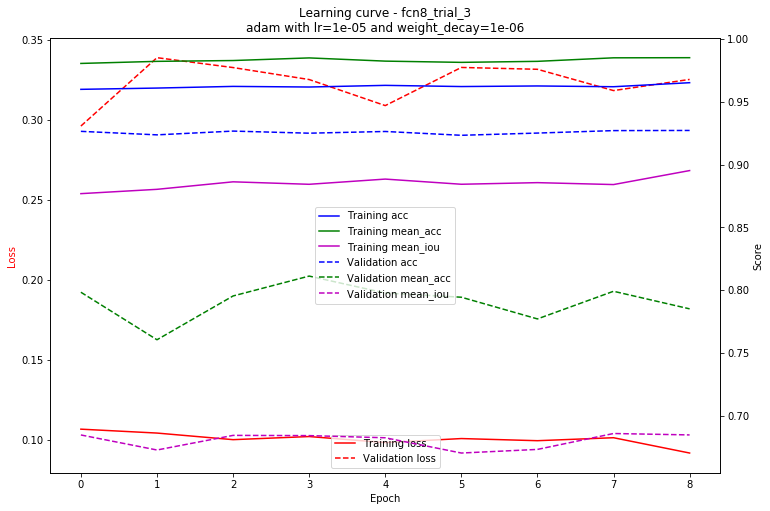

In [7]:
fcn_run_loop.fit_model(model, 60, FLAGS.batch_size, datasets[0], datasets[1], 'fcn8_trial_3', initial_epoch=50)

<b>Staged FCN16 training</b> using pre-trained weights from FCN32<br>
<b>Notes:</b> 
 - It takes more epochs overall to converge compared to one-off training, and 
 - It yields the same mIoU result (67.5) despite this additional training.

One-off FCN16 end-to-end training using pascal_plus
Building FCN16 for end-to-end training...
Restoring FCN32 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/pascal_plus\fcn32_trial_1-25
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-11T21:09:54.104005
Epoch 1/30, LR=9.999999747378752e-06
loss = 0.655, acc = 0.804, mean_acc = 0.678, mean_iou = 0.401, val_loss = 0.381, val_acc = 0.876, val_mean_acc = 0.559, val_mean_iou = 0.474
2019-02-11T21:24:50.754679

Epoch 2/30, LR=9.999999747378752e-06
loss = 0.467, acc = 0.846, mean_acc = 0.785, mean_iou = 0.515, val_loss = 0.325, val_acc = 0.892, val_mean_acc = 0.707, val_mean_iou = 0.562
2019-02-11T21:39:41.931376

Epoch 3/30, LR=9.999999747378752e-06
loss = 0.422, acc = 0.858, mean_acc = 0.813, mean_iou = 0.549, val_loss = 0.288, val_acc = 0.905, val_mean_acc = 0.751, val_mean_iou = 0.613

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

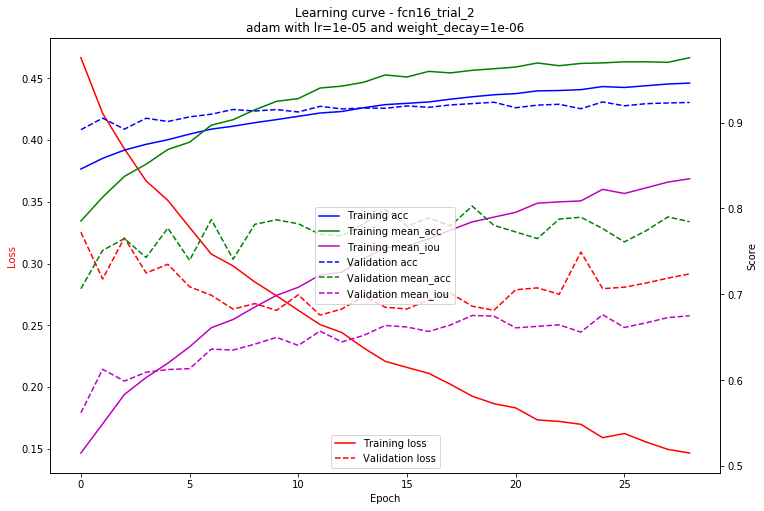

In [5]:
FLAGS.n_epochs = 30
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_2', saved_variables='fcn32_trial_1-25')

<b>Staged FCN8 training</b> using pre-trained weights from FCN16<br>
<b>Notes:</b> 
 - It takes more epochs overall to converge compared to one-off training, and 
 - It seems it won't yield as good mIoU result as one-off training (68.5). I did not want to train any longer here.

One-off FCN8 end-to-end training using pascal_plus
Building FCN8 for end-to-end training...
Restoring FCN16 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/pascal_plus\fcn16_trial_2-30
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-13T08:22:41.841381
Epoch 1/40, LR=9.999999747378752e-06
loss = 0.674, acc = 0.798, mean_acc = 0.654, mean_iou = 0.378, val_loss = 0.375, val_acc = 0.878, val_mean_acc = 0.683, val_mean_iou = 0.519
2019-02-13T08:40:46.238759

Epoch 2/40, LR=9.999999747378752e-06
loss = 0.485, acc = 0.842, mean_acc = 0.774, mean_iou = 0.498, val_loss = 0.327, val_acc = 0.895, val_mean_acc = 0.691, val_mean_iou = 0.563
2019-02-13T08:58:31.604545

Epoch 3/40, LR=9.999999747378752e-06
loss = 0.448, acc = 0.852, mean_acc = 0.802, mean_iou = 0.530, val_loss = 0.312, val_acc = 0.897, val_mean_acc = 0.721, val_mean_iou = 0.585
2

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

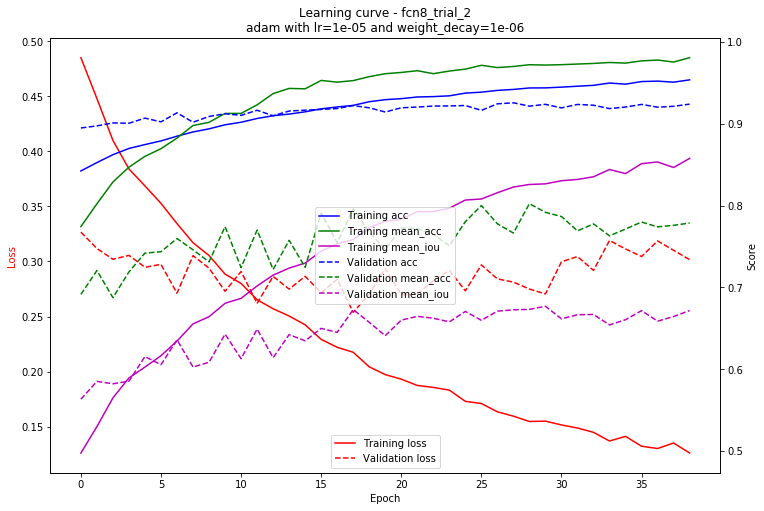

In [6]:
FLAGS.n_epochs = 40
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_2', saved_variables='fcn16_trial_2-30')

Once you are satisfied with one of your PASCAL Plus models, you may want to visualize the predictions. The next cell will save images of the validation set masked with pixel-level semantic predictions. A new folder is created each time.

In [9]:
from pascal_plus_dataset import PascalPlusDataset
dataset = PascalPlusDataset(AUGMENTATION_PARAMS)
dataset.predict_dataset(PREDICTIONS_PATH, os.path.join(DATASET_PATH, 'TFRecords', 'segmentation_val.tfrecords'), 
                        model, FLAGS.batch_size)

Saving predictions to G:/Datasets/pascal_plus_data/prepared/predictions/2019-02-15T08H41


By default, the training procedure saves only the weights of the model. If you would like to save the graph and optimizer state, to resume training later on for instance, then you need to save it manually as follows:

In [10]:
model.save_protobuf(os.path.join(SAVED_MODELS_PATH, 'fcn8_trial_3'), tags=['FCN8', 'VGG16'])

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: G:/Datasets/trained_models/tensorflow/pascal_plus\fcn8_trial_3\saved_model.pb


### Pascal VOC 2012

<b>FCN32 training</b>

One-off FCN32 end-to-end training using pascal_voc_2012
Building FCN32 for end-to-end training...
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-09T13:29:05.399617
Epoch 1/100, LR=9.999999747378752e-06
loss = 1.169, acc = 0.724, mean_acc = 0.179, mean_iou = 0.149, val_loss = 0.535, val_acc = 0.833, val_mean_acc = 0.525, val_mean_iou = 0.380
2019-02-09T13:31:46.722268

Epoch 2/100, LR=9.999999747378752e-06
loss = 0.559, acc = 0.819, mean_acc = 0.503, mean_iou = 0.404, val_loss = 0.449, val_acc = 0.852, val_mean_acc = 0.619, val_mean_iou = 0.463
2019-02-09T13:34:16.487060

Epoch 3/100, LR=9.999999747378752e-06
loss = 0.480, acc = 0.844, mean_acc = 0.580, mean_iou = 0.477, val_loss = 0.424, val_acc = 0.859, val_mean_acc = 0.650, val_mean_iou = 0.496
2019-02-09T13:36:46.460829

Epoch 4/100, LR=9.999999747378752e-06
loss = 0.418, acc = 0.862, mean_acc = 0.636, mean_iou = 0.532, val_loss = 

2019-02-09T16:45:28.933170

Epoch 78/100, LR=9.999999747378752e-06
loss = 0.059, acc = 0.978, mean_acc = 0.954, mean_iou = 0.917, val_loss = 0.442, val_acc = 0.902, val_mean_acc = 0.700, val_mean_iou = 0.588
2019-02-09T16:48:05.782593

Epoch 79/100, LR=9.999999747378752e-06
loss = 0.057, acc = 0.979, mean_acc = 0.955, mean_iou = 0.919, val_loss = 0.430, val_acc = 0.903, val_mean_acc = 0.702, val_mean_iou = 0.591
2019-02-09T16:50:37.620800

Epoch 80/100, LR=9.999999747378752e-06
loss = 0.055, acc = 0.980, mean_acc = 0.953, mean_iou = 0.917, val_loss = 0.424, val_acc = 0.906, val_mean_acc = 0.705, val_mean_iou = 0.602
2019-02-09T16:53:09.035178

Epoch 81/100, LR=9.999999747378752e-06
loss = 0.057, acc = 0.979, mean_acc = 0.953, mean_iou = 0.917, val_loss = 0.445, val_acc = 0.904, val_mean_acc = 0.706, val_mean_iou = 0.598
2019-02-09T16:55:40.992809

Epoch 82/100, LR=9.999999747378752e-06
loss = 0.054, acc = 0.980, mean_acc = 0.958, mean_iou = 0.924, val_loss = 0.433, val_acc = 0.906, val

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

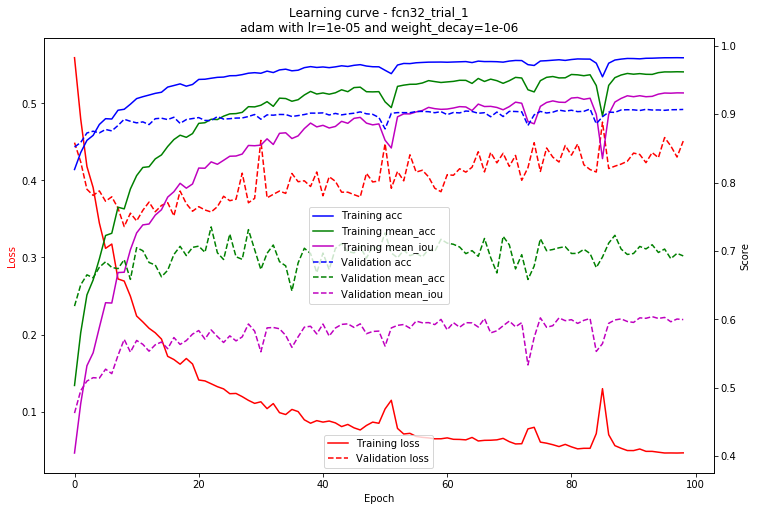

In [5]:
FLAGS.n_epochs = 100
model, datasets = fcn_run_loop.oneoff_training('FCN32', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn32_trial_1')

<b>One-off FCN16 training</b>

One-off FCN16 end-to-end training using pascal_voc_2012
Building FCN16 for end-to-end training...
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-09T17:57:57.593798
Epoch 1/100, LR=9.999999747378752e-06
loss = 1.097, acc = 0.735, mean_acc = 0.212, mean_iou = 0.172, val_loss = 0.492, val_acc = 0.846, val_mean_acc = 0.551, val_mean_iou = 0.404
2019-02-09T18:00:41.521332

Epoch 2/100, LR=9.999999747378752e-06
loss = 0.543, acc = 0.830, mean_acc = 0.524, mean_iou = 0.424, val_loss = 0.422, val_acc = 0.864, val_mean_acc = 0.625, val_mean_iou = 0.479
2019-02-09T18:03:12.187087

Epoch 3/100, LR=9.999999747378752e-06
loss = 0.443, acc = 0.856, mean_acc = 0.607, mean_iou = 0.502, val_loss = 0.420, val_acc = 0.869, val_mean_acc = 0.627, val_mean_iou = 0.488
2019-02-09T18:05:42.939257

Epoch 4/100, LR=9.999999747378752e-06
loss = 0.409, acc = 0.867, mean_acc = 0.646, mean_iou = 0.541, val_loss = 

2019-02-09T21:13:20.857722

Epoch 78/100, LR=9.999999747378752e-06
loss = 0.044, acc = 0.984, mean_acc = 0.966, mean_iou = 0.938, val_loss = 0.416, val_acc = 0.911, val_mean_acc = 0.697, val_mean_iou = 0.611
2019-02-09T21:15:52.041738
Saving model checkpoint

Epoch 79/100, LR=9.999999747378752e-06
loss = 0.045, acc = 0.984, mean_acc = 0.966, mean_iou = 0.938, val_loss = 0.398, val_acc = 0.910, val_mean_acc = 0.734, val_mean_iou = 0.621
2019-02-09T21:18:28.959866

Epoch 80/100, LR=9.999999747378752e-06
loss = 0.046, acc = 0.984, mean_acc = 0.966, mean_iou = 0.937, val_loss = 0.411, val_acc = 0.910, val_mean_acc = 0.714, val_mean_iou = 0.615
2019-02-09T21:20:59.991033

Epoch 81/100, LR=9.999999747378752e-06
loss = 0.048, acc = 0.983, mean_acc = 0.965, mean_iou = 0.935, val_loss = 0.410, val_acc = 0.908, val_mean_acc = 0.743, val_mean_iou = 0.617
2019-02-09T21:23:31.067151

Epoch 82/100, LR=9.999999747378752e-06
loss = 0.046, acc = 0.984, mean_acc = 0.965, mean_iou = 0.935, val_loss = 0.4

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

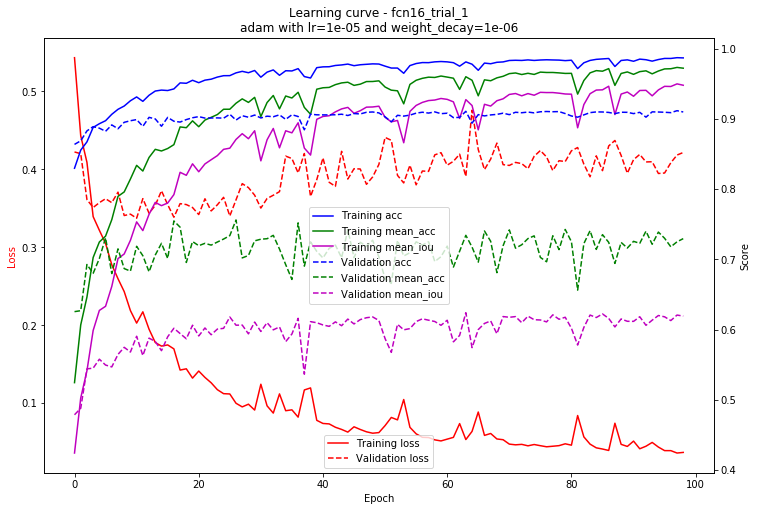

In [5]:
FLAGS.n_epochs = 100
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_1')

<b>One-off FCN8 training</b><br>
<b>Note:</b> give it enough epochs and it will do as good as or slightly better than FCN16.

One-off FCN8 end-to-end training using pascal_voc_2012
Building FCN8 for end-to-end training...
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-15T21:39:43.304193
Epoch 1/110, LR=9.999999747378752e-06
loss = 1.091, acc = 0.742, mean_acc = 0.221, mean_iou = 0.178, val_loss = 0.522, val_acc = 0.851, val_mean_acc = 0.438, val_mean_iou = 0.364
2019-02-15T21:42:24.284479

Epoch 2/110, LR=9.999999747378752e-06
loss = 0.560, acc = 0.826, mean_acc = 0.515, mean_iou = 0.411, val_loss = 0.446, val_acc = 0.868, val_mean_acc = 0.518, val_mean_iou = 0.448
2019-02-15T21:44:54.765558

Epoch 3/110, LR=9.999999747378752e-06
loss = 0.446, acc = 0.858, mean_acc = 0.610, mean_iou = 0.503, val_loss = 0.426, val_acc = 0.865, val_mean_acc = 0.660, val_mean_iou = 0.485
2019-02-15T21:47:25.601201

Epoch 4/110, LR=9.999999747378752e-06
loss = 0.417, acc = 0.867, mean_acc = 0.650, mean_iou = 0.543, val_loss = 0.

2019-02-15T23:15:06.189454

Epoch 38/110, LR=9.999999747378752e-06
loss = 0.100, acc = 0.967, mean_acc = 0.928, mean_iou = 0.879, val_loss = 0.431, val_acc = 0.899, val_mean_acc = 0.692, val_mean_iou = 0.596
2019-02-15T23:17:37.442734

Epoch 39/110, LR=9.999999747378752e-06
loss = 0.084, acc = 0.971, mean_acc = 0.937, mean_iou = 0.893, val_loss = 0.405, val_acc = 0.907, val_mean_acc = 0.701, val_mean_iou = 0.607
2019-02-15T23:20:08.658353
Saving model checkpoint

Epoch 40/110, LR=9.999999747378752e-06
loss = 0.079, acc = 0.973, mean_acc = 0.941, mean_iou = 0.898, val_loss = 0.379, val_acc = 0.905, val_mean_acc = 0.735, val_mean_iou = 0.615
2019-02-15T23:22:44.872286
Saving model checkpoint

Epoch 41/110, LR=9.999999747378752e-06
loss = 0.080, acc = 0.972, mean_acc = 0.940, mean_iou = 0.897, val_loss = 0.373, val_acc = 0.906, val_mean_acc = 0.736, val_mean_iou = 0.613
2019-02-15T23:25:21.160141

Epoch 42/110, LR=9.999999747378752e-06
loss = 0.076, acc = 0.974, mean_acc = 0.944, mean_iou

2019-02-16T00:52:17.709347
Saving learning curve
Saving model checkpoint

Epoch 76/110, LR=9.999999747378752e-06
loss = 0.046, acc = 0.984, mean_acc = 0.967, mean_iou = 0.939, val_loss = 0.445, val_acc = 0.910, val_mean_acc = 0.709, val_mean_iou = 0.613
2019-02-16T00:54:54.444436

Epoch 77/110, LR=9.999999747378752e-06
loss = 0.070, acc = 0.978, mean_acc = 0.954, mean_iou = 0.917, val_loss = 0.528, val_acc = 0.888, val_mean_acc = 0.639, val_mean_iou = 0.542
2019-02-16T00:57:25.965094

Epoch 78/110, LR=9.999999747378752e-06
loss = 0.059, acc = 0.980, mean_acc = 0.955, mean_iou = 0.920, val_loss = 0.407, val_acc = 0.910, val_mean_acc = 0.734, val_mean_iou = 0.623
2019-02-16T00:59:57.519895

Epoch 79/110, LR=9.999999747378752e-06
loss = 0.050, acc = 0.982, mean_acc = 0.964, mean_iou = 0.935, val_loss = 0.415, val_acc = 0.905, val_mean_acc = 0.735, val_mean_iou = 0.607
2019-02-16T01:02:29.163965

Epoch 80/110, LR=9.999999747378752e-06
loss = 0.047, acc = 0.984, mean_acc = 0.967, mean_iou =

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

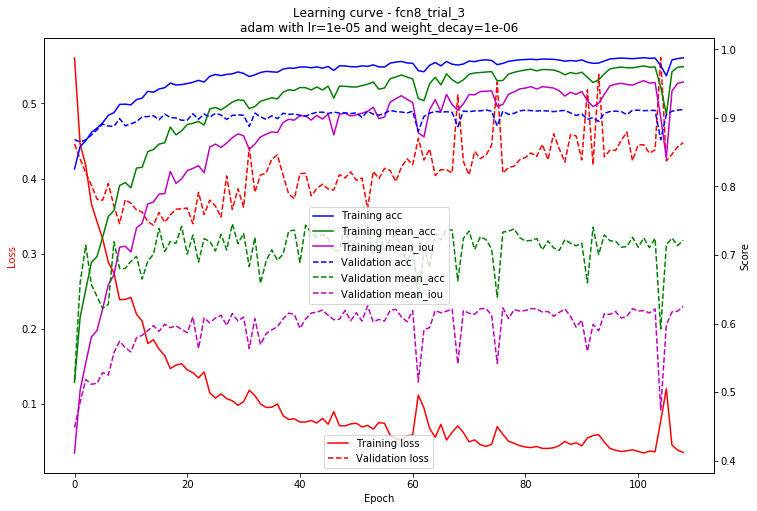

In [4]:
FLAGS.n_epochs = 110
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_3')

<b>Staged FCN16 training</b> using pre-trained weights from FCN32<br>
<b>Note:</b> it takes more epochs to converge compared to one-off FCN16 training for the same validation mIoU (61.9)

One-off FCN16 end-to-end training using pascal_voc_2012
Building FCN16 for end-to-end training...
Restoring FCN32 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/pascal_voc_2012\fcn32_trial_1-100
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-13T22:08:03.993755
Epoch 1/75, LR=9.999999747378752e-06
loss = 1.077, acc = 0.740, mean_acc = 0.224, mean_iou = 0.183, val_loss = 0.510, val_acc = 0.849, val_mean_acc = 0.464, val_mean_iou = 0.384
2019-02-13T22:10:44.912524

Epoch 2/75, LR=9.999999747378752e-06
loss = 0.541, acc = 0.829, mean_acc = 0.528, mean_iou = 0.427, val_loss = 0.420, val_acc = 0.873, val_mean_acc = 0.593, val_mean_iou = 0.477
2019-02-13T22:13:16.022831

Epoch 3/75, LR=9.999999747378752e-06
loss = 0.461, acc = 0.851, mean_acc = 0.603, mean_iou = 0.500, val_loss = 0.369, val_acc = 0.880, val_mean_acc = 0.682, val_mean_io

2019-02-14T01:18:16.863949

Epoch 75/75, LR=9.999999747378752e-06
loss = 0.049, acc = 0.983, mean_acc = 0.964, mean_iou = 0.934, val_loss = 0.413, val_acc = 0.911, val_mean_acc = 0.723, val_mean_iou = 0.619
2019-02-14T01:20:48.630928
Saving learning curve
Saving model checkpoint

Total steps = 9150


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

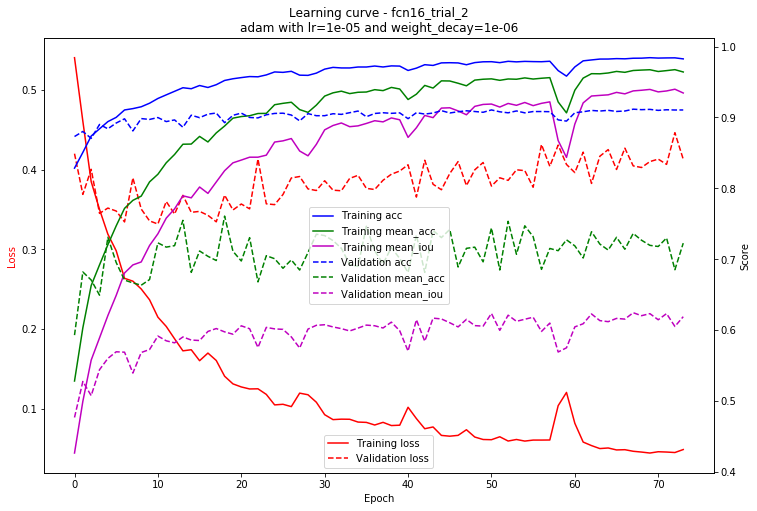

In [6]:
FLAGS.n_epochs = 75
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_2', saved_variables='fcn32_trial_1-100')

<b>Staged FCN8 training</b> using pre-trained weights from FCN16<br>
<b>Note:</b> it yields no improvement despite training for more epochs so one-off training is preferable for FCN8.

One-off FCN8 end-to-end training using pascal_voc_2012
Building FCN8 for end-to-end training...
Restoring FCN16 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/pascal_voc_2012\fcn16_trial_2-75
Applying fixed learning rate of 1e-05
logits = (?, 22)
labels = (?, 512, 512)
Adam optimizer with weight decay = 1e-06
Model build successful
2019-02-14T01:21:09.345193
Epoch 1/75, LR=9.999999747378752e-06
loss = 1.114, acc = 0.732, mean_acc = 0.214, mean_iou = 0.168, val_loss = 0.547, val_acc = 0.832, val_mean_acc = 0.477, val_mean_iou = 0.333
2019-02-14T01:23:45.541559

Epoch 2/75, LR=9.999999747378752e-06
loss = 0.566, acc = 0.821, mean_acc = 0.510, mean_iou = 0.405, val_loss = 0.435, val_acc = 0.866, val_mean_acc = 0.568, val_mean_iou = 0.461
2019-02-14T01:26:17.382676

Epoch 3/75, LR=9.999999747378752e-06
loss = 0.488, acc = 0.847, mean_acc = 0.576, mean_iou = 0.468, val_loss = 0.419, val_acc = 0.872, val_mean_acc = 0.613, val_mean_iou =


Epoch 37/75, LR=9.999999747378752e-06
loss = 0.086, acc = 0.970, mean_acc = 0.934, mean_iou = 0.887, val_loss = 0.388, val_acc = 0.908, val_mean_acc = 0.732, val_mean_iou = 0.615
2019-02-14T02:56:00.641462

Epoch 38/75, LR=9.999999747378752e-06
loss = 0.097, acc = 0.967, mean_acc = 0.927, mean_iou = 0.873, val_loss = 0.440, val_acc = 0.904, val_mean_acc = 0.667, val_mean_iou = 0.587
2019-02-14T02:58:32.539269

Epoch 39/75, LR=9.999999747378752e-06
loss = 0.088, acc = 0.970, mean_acc = 0.934, mean_iou = 0.886, val_loss = 0.375, val_acc = 0.907, val_mean_acc = 0.712, val_mean_iou = 0.612
2019-02-14T03:01:04.586722

Epoch 40/75, LR=9.999999747378752e-06
loss = 0.083, acc = 0.972, mean_acc = 0.940, mean_iou = 0.897, val_loss = 0.386, val_acc = 0.904, val_mean_acc = 0.715, val_mean_iou = 0.605
2019-02-14T03:03:36.592385
Saving model checkpoint

Epoch 41/75, LR=9.999999747378752e-06
loss = 0.080, acc = 0.972, mean_acc = 0.940, mean_iou = 0.896, val_loss = 0.365, val_acc = 0.909, val_mean_ac

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

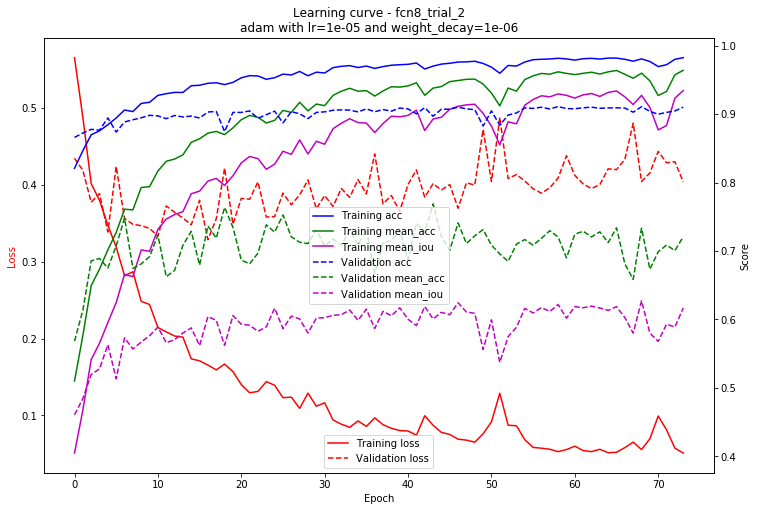

In [7]:
FLAGS.n_epochs = 75
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_2', saved_variables='fcn16_trial_2-75')

Once you are satisfied with one of your PASACL VOC 2012 models, you may want to visualize the predictions. The next cell will save images of the validation set masked with pixel-level semantic predictions. A new folder is created each time.

In [5]:
from pascal_voc_dataset import PascalVOC2012Dataset
dataset = PascalVOC2012Dataset(AUGMENTATION_PARAMS)
dataset.predict_dataset(PREDICTIONS_PATH, os.path.join(DATASET_PATH, 'TFRecords', 'segmentation_val.tfrecords'), 
                        model, FLAGS.batch_size)

Saving predictions to G:/Datasets/pascal_voc_data/VOCdevkit/VOC2012/predictions/2019-02-16T09H43


### CamVid

<b>One-off FCN32 training</b>

One-off FCN32 end-to-end training using cam_vid
Building FCN32 for end-to-end training...
Applying fixed learning rate of 0.0001
logits = (?, 12)
labels = (?, 384, 480)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T22:26:11.955581
Epoch 1/80, LR=9.999999747378752e-05
loss = 1.182, acc = 0.616, mean_acc = 0.326, mean_iou = 0.234, val_loss = 0.732, val_acc = 0.767, val_mean_acc = 0.387, val_mean_iou = 0.303
2019-02-08T22:26:39.610642

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.517, acc = 0.827, mean_acc = 0.507, mean_iou = 0.425, val_loss = 0.521, val_acc = 0.848, val_mean_acc = 0.486, val_mean_iou = 0.387
2019-02-08T22:27:02.912790

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.443, acc = 0.856, mean_acc = 0.534, mean_iou = 0.458, val_loss = 0.402, val_acc = 0.870, val_mean_acc = 0.537, val_mean_iou = 0.451
2019-02-08T22:27:26.131570

Epoch 4/80, LR=9.999999747378752e-05
loss = 0.381, acc = 0.872, mean_acc = 0.577, mean_iou = 0.500, val_loss = 0.376, val_acc = 0.8

2019-02-08T22:41:31.756137

Epoch 40/80, LR=9.999999747378752e-05
loss = 0.181, acc = 0.931, mean_acc = 0.824, mean_iou = 0.740, val_loss = 0.222, val_acc = 0.921, val_mean_acc = 0.737, val_mean_iou = 0.633
2019-02-08T22:41:55.045799

Epoch 41/80, LR=9.999999747378752e-05
loss = 0.182, acc = 0.930, mean_acc = 0.826, mean_iou = 0.738, val_loss = 0.222, val_acc = 0.925, val_mean_acc = 0.736, val_mean_iou = 0.644
2019-02-08T22:42:18.422351

Epoch 42/80, LR=9.999999747378752e-05
loss = 0.182, acc = 0.930, mean_acc = 0.825, mean_iou = 0.739, val_loss = 0.225, val_acc = 0.922, val_mean_acc = 0.747, val_mean_iou = 0.643
2019-02-08T22:42:41.712119

Epoch 43/80, LR=9.999999747378752e-05
loss = 0.179, acc = 0.931, mean_acc = 0.832, mean_iou = 0.745, val_loss = 0.224, val_acc = 0.924, val_mean_acc = 0.752, val_mean_iou = 0.648
2019-02-08T22:43:04.954039

Epoch 44/80, LR=9.999999747378752e-05
loss = 0.178, acc = 0.931, mean_acc = 0.829, mean_iou = 0.744, val_loss = 0.227, val_acc = 0.923, val_mean

Epoch 79/80, LR=9.999999747378752e-05
loss = 0.162, acc = 0.935, mean_acc = 0.846, mean_iou = 0.761, val_loss = 0.217, val_acc = 0.925, val_mean_acc = 0.737, val_mean_iou = 0.647
2019-02-08T22:56:52.556932

Epoch 80/80, LR=9.999999747378752e-05
loss = 0.160, acc = 0.936, mean_acc = 0.846, mean_iou = 0.764, val_loss = 0.210, val_acc = 0.926, val_mean_acc = 0.734, val_mean_iou = 0.650
2019-02-08T22:57:15.025802
Saving learning curve
Saving model checkpoint

Total steps = 1760


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

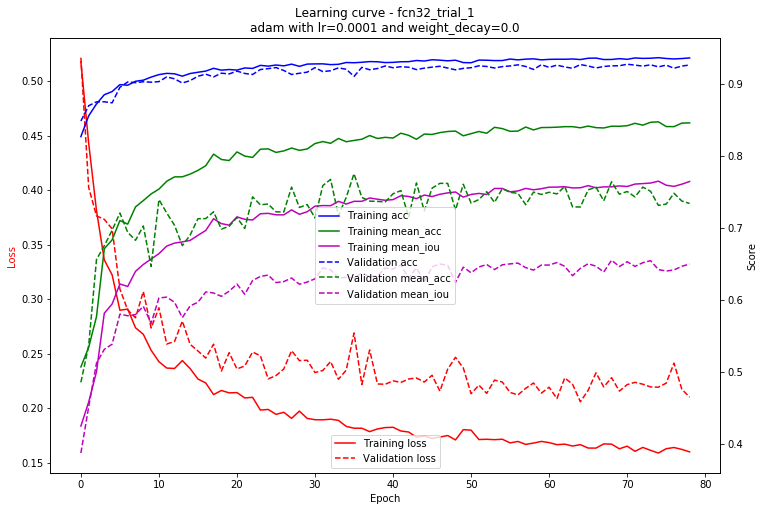

In [17]:
FLAGS.batch_size = 16
FLAGS.n_epochs = 80
FLAGS.weight_decay = 0.
model, datasets = fcn_run_loop.oneoff_training('FCN32', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn32_trial_1')

<b>One-off FCN16 training</b><br>
<b>Note:</b> it yields a sharply better result (70.4 mIoU) than FCN32 (65.0) for the same number of training epochs.

One-off FCN16 end-to-end training using cam_vid
Building FCN16 for end-to-end training...
Applying fixed learning rate of 0.0001
logits = (?, 12)
labels = (?, 384, 480)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T22:58:08.879842
Epoch 1/80, LR=9.999999747378752e-05
loss = 0.744, acc = 0.776, mean_acc = 0.465, mean_iou = 0.380, val_loss = 0.450, val_acc = 0.869, val_mean_acc = 0.532, val_mean_iou = 0.430
2019-02-08T22:58:35.649213

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.358, acc = 0.885, mean_acc = 0.608, mean_iou = 0.536, val_loss = 0.312, val_acc = 0.891, val_mean_acc = 0.658, val_mean_iou = 0.534
2019-02-08T22:58:57.936786

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.315, acc = 0.895, mean_acc = 0.682, mean_iou = 0.600, val_loss = 0.269, val_acc = 0.901, val_mean_acc = 0.660, val_mean_iou = 0.570
2019-02-08T22:59:20.254968

Epoch 4/80, LR=9.999999747378752e-05
loss = 0.264, acc = 0.912, mean_acc = 0.721, mean_iou = 0.641, val_loss = 0.240, val_acc = 0.9

2019-02-08T23:12:59.450201

Epoch 40/80, LR=9.999999747378752e-05
loss = 0.132, acc = 0.950, mean_acc = 0.880, mean_iou = 0.806, val_loss = 0.207, val_acc = 0.935, val_mean_acc = 0.784, val_mean_iou = 0.694
2019-02-08T23:13:22.374465

Epoch 41/80, LR=9.999999747378752e-05
loss = 0.134, acc = 0.948, mean_acc = 0.881, mean_iou = 0.807, val_loss = 0.195, val_acc = 0.938, val_mean_acc = 0.795, val_mean_iou = 0.703
2019-02-08T23:13:45.349144

Epoch 42/80, LR=9.999999747378752e-05
loss = 0.129, acc = 0.951, mean_acc = 0.883, mean_iou = 0.811, val_loss = 0.203, val_acc = 0.936, val_mean_acc = 0.789, val_mean_iou = 0.697
2019-02-08T23:14:08.246961

Epoch 43/80, LR=9.999999747378752e-05
loss = 0.131, acc = 0.949, mean_acc = 0.882, mean_iou = 0.809, val_loss = 0.206, val_acc = 0.935, val_mean_acc = 0.786, val_mean_iou = 0.692
2019-02-08T23:14:31.243237

Epoch 44/80, LR=9.999999747378752e-05
loss = 0.131, acc = 0.949, mean_acc = 0.876, mean_iou = 0.802, val_loss = 0.205, val_acc = 0.936, val_mean

Epoch 79/80, LR=9.999999747378752e-05
loss = 0.116, acc = 0.953, mean_acc = 0.898, mean_iou = 0.829, val_loss = 0.202, val_acc = 0.938, val_mean_acc = 0.776, val_mean_iou = 0.698
2019-02-08T23:28:08.522974

Epoch 80/80, LR=9.999999747378752e-05
loss = 0.116, acc = 0.954, mean_acc = 0.897, mean_iou = 0.829, val_loss = 0.197, val_acc = 0.939, val_mean_acc = 0.792, val_mean_iou = 0.704
2019-02-08T23:28:30.823325
Saving learning curve
Saving model checkpoint

Total steps = 1760


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

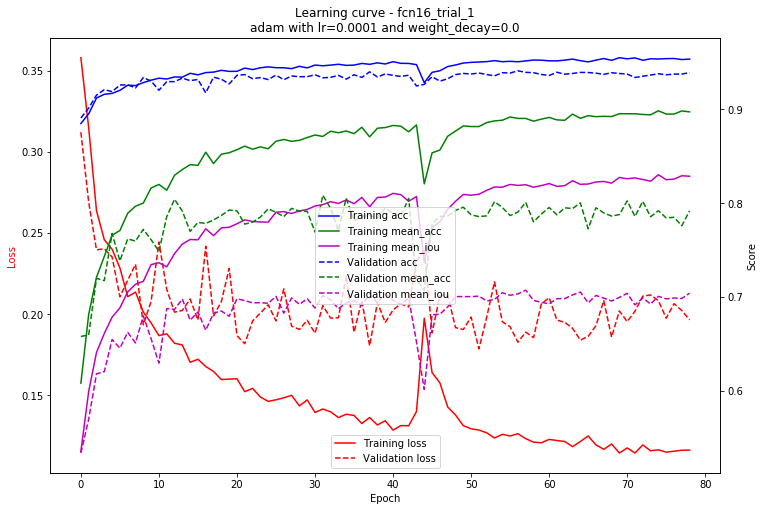

In [ ]:
FLAGS.batch_size = 16
FLAGS.n_epochs = 80
FLAGS.weight_decay = 0.
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_1')

<b>One-off FCN8 training</b><br>
<b>Note:</b> another large improvement compared to FCN16 with 73.2 mIoU. CamVid is the only dataset showing such improvement.

One-off FCN8 end-to-end training using cam_vid
Building FCN8 for end-to-end training...
Applying fixed learning rate of 0.0001
logits = (?, 12)
labels = (?, 384, 480)
Adam optimizer w/o weight decay
Model build successful
2019-02-09T10:55:22.589568
Epoch 1/120, LR=9.999999747378752e-05
loss = 1.388, acc = 0.652, mean_acc = 0.306, mean_iou = 0.226, val_loss = 0.652, val_acc = 0.809, val_mean_acc = 0.453, val_mean_iou = 0.360
2019-02-09T10:55:54.656815

Epoch 2/120, LR=9.999999747378752e-05
loss = 0.527, acc = 0.833, mean_acc = 0.450, mean_iou = 0.379, val_loss = 0.428, val_acc = 0.868, val_mean_acc = 0.561, val_mean_iou = 0.460
2019-02-09T10:56:15.882216

Epoch 3/120, LR=9.999999747378752e-05
loss = 0.413, acc = 0.866, mean_acc = 0.504, mean_iou = 0.436, val_loss = 0.355, val_acc = 0.890, val_mean_acc = 0.616, val_mean_iou = 0.510
2019-02-09T10:56:37.133194

Epoch 4/120, LR=9.999999747378752e-05
loss = 0.357, acc = 0.882, mean_acc = 0.555, mean_iou = 0.485, val_loss = 0.310, val_acc = 0

2019-02-09T11:23:28.882518

Epoch 78/120, LR=9.999999747378752e-05
loss = 0.113, acc = 0.955, mean_acc = 0.864, mean_iou = 0.797, val_loss = 0.178, val_acc = 0.946, val_mean_acc = 0.820, val_mean_iou = 0.733
2019-02-09T11:23:50.169613

Epoch 79/120, LR=9.999999747378752e-05
loss = 0.113, acc = 0.955, mean_acc = 0.861, mean_iou = 0.794, val_loss = 0.173, val_acc = 0.945, val_mean_acc = 0.807, val_mean_iou = 0.721
2019-02-09T11:24:11.478552

Epoch 80/120, LR=9.999999747378752e-05
loss = 0.114, acc = 0.955, mean_acc = 0.861, mean_iou = 0.794, val_loss = 0.193, val_acc = 0.943, val_mean_acc = 0.818, val_mean_iou = 0.721
2019-02-09T11:24:32.767069

Epoch 81/120, LR=9.999999747378752e-05
loss = 0.110, acc = 0.956, mean_acc = 0.864, mean_iou = 0.798, val_loss = 0.171, val_acc = 0.945, val_mean_acc = 0.809, val_mean_iou = 0.725
2019-02-09T11:24:54.070791

Epoch 82/120, LR=9.999999747378752e-05
loss = 0.111, acc = 0.956, mean_acc = 0.862, mean_iou = 0.796, val_loss = 0.173, val_acc = 0.945, val

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

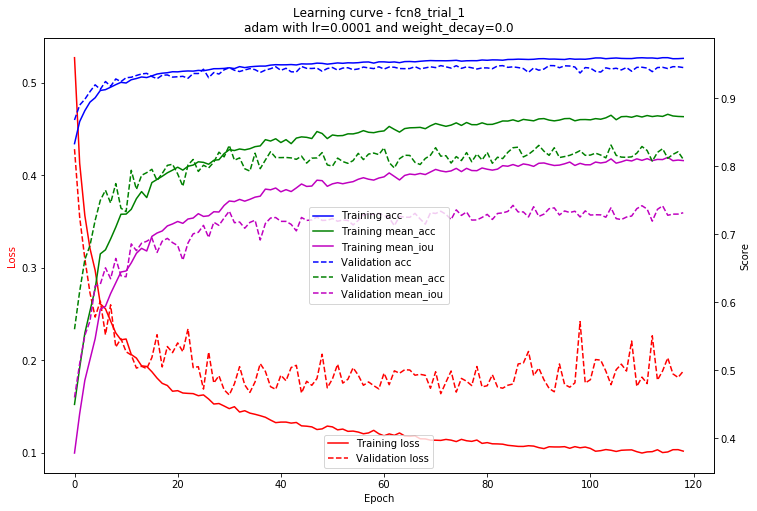

In [5]:
FLAGS.batch_size = 16
FLAGS.n_epochs = 120
FLAGS.weight_decay = 0.
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_1')

<b>Staged FCN16 training</b> using pre-trained weights from FCN32<br>
<b>Note:</b> reaches mIoU of 69.7 which is slightly lower than the one for one-off training (70.4)

One-off FCN16 end-to-end training using cam_vid
Building FCN16 for end-to-end training...
Restoring FCN32 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/cam_vid\fcn32_trial_1-80
Applying fixed learning rate of 0.0001
logits = (?, 12)
labels = (?, 384, 480)
Adam optimizer w/o weight decay
Model build successful
2019-02-09T11:50:18.680055
Epoch 1/80, LR=9.999999747378752e-05
loss = 0.771, acc = 0.760, mean_acc = 0.395, mean_iou = 0.315, val_loss = 0.458, val_acc = 0.863, val_mean_acc = 0.494, val_mean_iou = 0.422
2019-02-09T11:50:44.281775

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.386, acc = 0.875, mean_acc = 0.521, mean_iou = 0.452, val_loss = 0.331, val_acc = 0.884, val_mean_acc = 0.612, val_mean_iou = 0.497
2019-02-09T11:51:05.424144

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.320, acc = 0.893, mean_acc = 0.600, mean_iou = 0.523, val_loss = 0.270, val_acc = 0.905, val_mean_acc = 0.679, val_mean_iou = 0.574
2019-02-09T11:5

2019-02-09T12:04:06.281422

Epoch 39/80, LR=9.999999747378752e-05
loss = 0.145, acc = 0.944, mean_acc = 0.820, mean_iou = 0.745, val_loss = 0.194, val_acc = 0.936, val_mean_acc = 0.804, val_mean_iou = 0.701
2019-02-09T12:04:28.192474

Epoch 40/80, LR=9.999999747378752e-05
loss = 0.143, acc = 0.945, mean_acc = 0.817, mean_iou = 0.741, val_loss = 0.224, val_acc = 0.934, val_mean_acc = 0.775, val_mean_iou = 0.683
2019-02-09T12:04:50.076157

Epoch 41/80, LR=9.999999747378752e-05
loss = 0.143, acc = 0.945, mean_acc = 0.819, mean_iou = 0.745, val_loss = 0.190, val_acc = 0.938, val_mean_acc = 0.800, val_mean_iou = 0.702
2019-02-09T12:05:11.968216

Epoch 42/80, LR=9.999999747378752e-05
loss = 0.143, acc = 0.945, mean_acc = 0.819, mean_iou = 0.745, val_loss = 0.199, val_acc = 0.936, val_mean_acc = 0.799, val_mean_iou = 0.697
2019-02-09T12:05:33.838766

Epoch 43/80, LR=9.999999747378752e-05
loss = 0.143, acc = 0.945, mean_acc = 0.819, mean_iou = 0.744, val_loss = 0.203, val_acc = 0.937, val_mean

Epoch 78/80, LR=9.999999747378752e-05
loss = 0.126, acc = 0.950, mean_acc = 0.837, mean_iou = 0.766, val_loss = 0.193, val_acc = 0.939, val_mean_acc = 0.788, val_mean_iou = 0.702
2019-02-09T12:18:36.092661

Epoch 79/80, LR=9.999999747378752e-05
loss = 0.126, acc = 0.950, mean_acc = 0.838, mean_iou = 0.765, val_loss = 0.202, val_acc = 0.939, val_mean_acc = 0.785, val_mean_iou = 0.701
2019-02-09T12:18:57.320134

Epoch 80/80, LR=9.999999747378752e-05
loss = 0.124, acc = 0.951, mean_acc = 0.837, mean_iou = 0.768, val_loss = 0.210, val_acc = 0.938, val_mean_acc = 0.779, val_mean_iou = 0.697
2019-02-09T12:19:18.519306
Saving learning curve
Saving model checkpoint

Total steps = 1760


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

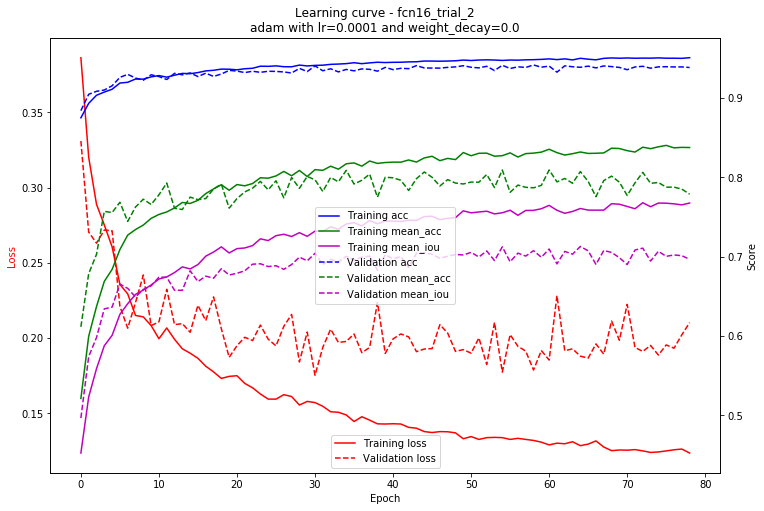

In [6]:
FLAGS.n_epochs = 80
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_2', saved_variables='fcn32_trial_1-80')

<b>Staged FCN8 training</b> using pre-trained weights from FCN16<br>
<b>Note:</b> again, staged training is slightly inferior to one-off training for FCN8 (72.9 versus 73.2).

One-off FCN8 end-to-end training using cam_vid
Building FCN8 for end-to-end training...
Restoring FCN16 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/cam_vid\fcn16_trial_2-80
Applying fixed learning rate of 0.0001
logits = (?, 12)
labels = (?, 384, 480)
Adam optimizer w/o weight decay
Model build successful
2019-02-09T12:37:15.891019
Epoch 1/80, LR=9.999999747378752e-05
loss = 1.373, acc = 0.649, mean_acc = 0.312, mean_iou = 0.231, val_loss = 0.704, val_acc = 0.794, val_mean_acc = 0.434, val_mean_iou = 0.354
2019-02-09T12:37:41.447890

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.522, acc = 0.834, mean_acc = 0.446, mean_iou = 0.379, val_loss = 0.425, val_acc = 0.864, val_mean_acc = 0.532, val_mean_iou = 0.445
2019-02-09T12:38:02.607563

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.393, acc = 0.875, mean_acc = 0.523, mean_iou = 0.455, val_loss = 0.353, val_acc = 0.888, val_mean_acc = 0.601, val_mean_iou = 0.512
2019-02-09T12:38:

2019-02-09T12:51:03.200489

Epoch 39/80, LR=9.999999747378752e-05
loss = 0.137, acc = 0.948, mean_acc = 0.834, mean_iou = 0.760, val_loss = 0.167, val_acc = 0.946, val_mean_acc = 0.793, val_mean_iou = 0.720
2019-02-09T12:51:24.623958

Epoch 40/80, LR=9.999999747378752e-05
loss = 0.137, acc = 0.949, mean_acc = 0.835, mean_iou = 0.761, val_loss = 0.183, val_acc = 0.943, val_mean_acc = 0.815, val_mean_iou = 0.719
2019-02-09T12:51:45.994945

Epoch 41/80, LR=9.999999747378752e-05
loss = 0.137, acc = 0.948, mean_acc = 0.839, mean_iou = 0.766, val_loss = 0.175, val_acc = 0.946, val_mean_acc = 0.805, val_mean_iou = 0.720
2019-02-09T12:52:07.407909

Epoch 42/80, LR=9.999999747378752e-05
loss = 0.136, acc = 0.948, mean_acc = 0.833, mean_iou = 0.760, val_loss = 0.163, val_acc = 0.946, val_mean_acc = 0.807, val_mean_iou = 0.729
2019-02-09T12:52:28.842688

Epoch 43/80, LR=9.999999747378752e-05
loss = 0.138, acc = 0.947, mean_acc = 0.833, mean_iou = 0.762, val_loss = 0.171, val_acc = 0.944, val_mean

Epoch 78/80, LR=9.999999747378752e-05
loss = 0.112, acc = 0.956, mean_acc = 0.864, mean_iou = 0.798, val_loss = 0.171, val_acc = 0.947, val_mean_acc = 0.816, val_mean_iou = 0.728
2019-02-09T13:05:54.537415

Epoch 79/80, LR=9.999999747378752e-05
loss = 0.112, acc = 0.956, mean_acc = 0.864, mean_iou = 0.797, val_loss = 0.165, val_acc = 0.948, val_mean_acc = 0.816, val_mean_iou = 0.733
2019-02-09T13:06:16.751224

Epoch 80/80, LR=9.999999747378752e-05
loss = 0.111, acc = 0.956, mean_acc = 0.864, mean_iou = 0.797, val_loss = 0.176, val_acc = 0.946, val_mean_acc = 0.815, val_mean_iou = 0.729
2019-02-09T13:06:38.923464
Saving learning curve
Saving model checkpoint

Total steps = 1760


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

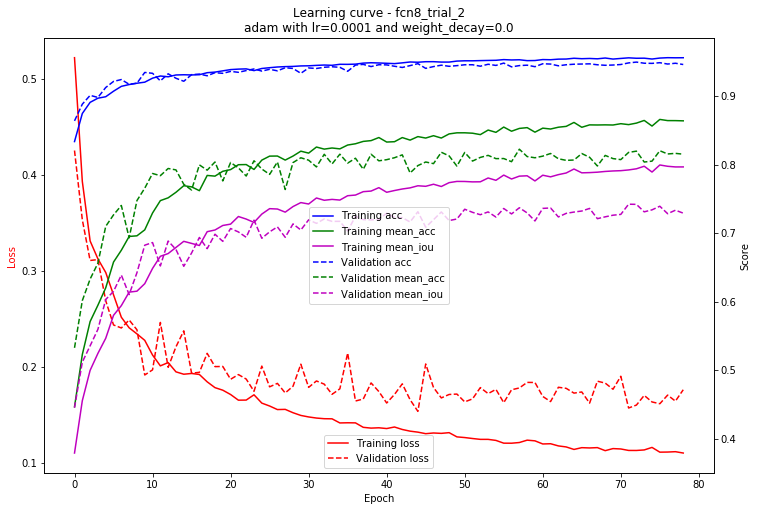

In [7]:
FLAGS.n_epochs = 80
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_2', saved_variables='fcn16_trial_2-80')

Once you are satisfied with one of your CamVid models, you may want to visualize the predictions. The next cell will save images of the validation set masked with pixel-level semantic predictions. A new folder is created each time.

In [5]:
from cam_vid_dataset import CamVidDataset
dataset = CamVidDataset(AUGMENTATION_PARAMS)
dataset.predict_dataset(PREDICTIONS_PATH, os.path.join(DATASET_PATH, 'TFRecords', 'segmentation_val.tfrecords'), 
                        model, FLAGS.batch_size)

Saving predictions to G:/Datasets/cam_vid/predictions/2019-02-15T20H18


### KittyRoad

<b>One-off FCN32 training</b><br>
<b>Oucome: mIoU 93.8</b>

One-off FCN32 end-to-end training using kitty_road
Building FCN32 for end-to-end training...
Applying fixed learning rate of 0.0001
logits = (?, 3)
labels = (?, 192, 640)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T15:32:15.996773
Epoch 1/40, LR=9.999999747378752e-05
loss = 0.460, acc = 0.840, mean_acc = 0.613, mean_iou = 0.525, val_loss = 0.430, val_acc = 0.846, val_mean_acc = 0.902, val_mean_iou = 0.665
2019-02-08T15:32:32.081429

Epoch 2/40, LR=9.999999747378752e-05
loss = 0.176, acc = 0.928, mean_acc = 0.922, mean_iou = 0.808, val_loss = 0.152, val_acc = 0.940, val_mean_acc = 0.946, val_mean_iou = 0.830
2019-02-08T15:32:43.776147

Epoch 3/40, LR=9.999999747378752e-05
loss = 0.122, acc = 0.948, mean_acc = 0.940, mean_iou = 0.850, val_loss = 0.115, val_acc = 0.951, val_mean_acc = 0.905, val_mean_iou = 0.848
2019-02-08T15:32:55.489836

Epoch 4/40, LR=9.999999747378752e-05
loss = 0.096, acc = 0.961, mean_acc = 0.950, mean_iou = 0.884, val_loss = 0.108, val_acc = 0

2019-02-08T15:40:49.700853
Saving model checkpoint

Epoch 38/40, LR=9.999999747378752e-05
loss = 0.037, acc = 0.984, mean_acc = 0.980, mean_iou = 0.951, val_loss = 0.082, val_acc = 0.979, val_mean_acc = 0.972, val_mean_iou = 0.935
2019-02-08T15:41:06.229291

Epoch 39/40, LR=9.999999747378752e-05
loss = 0.038, acc = 0.985, mean_acc = 0.980, mean_iou = 0.951, val_loss = 0.080, val_acc = 0.980, val_mean_acc = 0.971, val_mean_iou = 0.935
2019-02-08T15:41:17.993547

Epoch 40/40, LR=9.999999747378752e-05
loss = 0.037, acc = 0.985, mean_acc = 0.980, mean_iou = 0.952, val_loss = 0.074, val_acc = 0.981, val_mean_acc = 0.973, val_mean_iou = 0.938
2019-02-08T15:41:29.769047
Saving learning curve
Saving model checkpoint

Total steps = 560


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

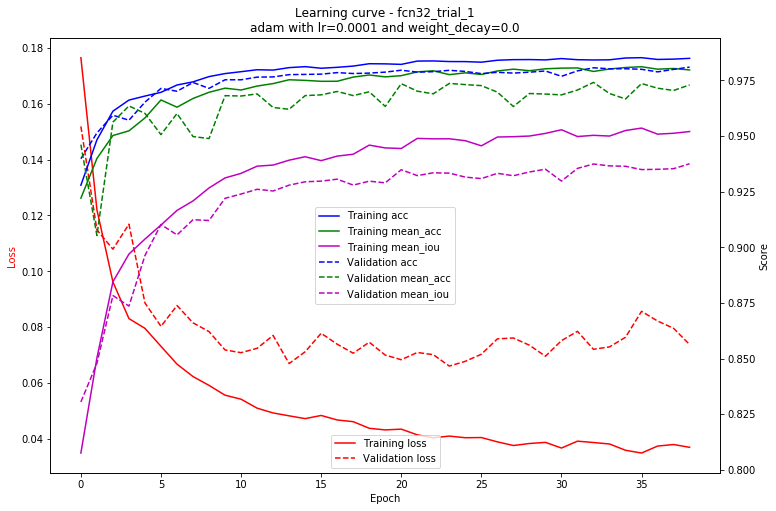

In [27]:
FLAGS.n_epochs = 40
model, datasets = fcn_run_loop.oneoff_training('FCN32', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn32_trial_1')

<b>One-off FCN16 training</b><br>
<b>Oucome: mIoU 95.6</b>

One-off FCN16 end-to-end training using kitty_road
Building FCN16 for end-to-end training...
Applying fixed learning rate of 0.0001
logits = (?, 3)
labels = (?, 192, 640)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T15:42:23.604413
Epoch 1/40, LR=9.999999747378752e-05
loss = 0.299, acc = 0.891, mean_acc = 0.788, mean_iou = 0.695, val_loss = 0.174, val_acc = 0.923, val_mean_acc = 0.946, val_mean_iou = 0.803
2019-02-08T15:42:39.934169

Epoch 2/40, LR=9.999999747378752e-05
loss = 0.120, acc = 0.951, mean_acc = 0.945, mean_iou = 0.858, val_loss = 0.143, val_acc = 0.948, val_mean_acc = 0.963, val_mean_iou = 0.854
2019-02-08T15:42:52.331368

Epoch 3/40, LR=9.999999747378752e-05
loss = 0.087, acc = 0.965, mean_acc = 0.961, mean_iou = 0.894, val_loss = 0.087, val_acc = 0.966, val_mean_acc = 0.952, val_mean_iou = 0.897
2019-02-08T15:43:04.520631

Epoch 4/40, LR=9.999999747378752e-05
loss = 0.074, acc = 0.970, mean_acc = 0.964, mean_iou = 0.906, val_loss = 0.085, val_acc = 0

2019-02-08T15:51:01.246847
Saving model checkpoint

Epoch 38/40, LR=9.999999747378752e-05
loss = 0.025, acc = 0.990, mean_acc = 0.988, mean_iou = 0.968, val_loss = 0.052, val_acc = 0.986, val_mean_acc = 0.981, val_mean_iou = 0.955
2019-02-08T15:51:18.087505
Saving model checkpoint

Epoch 39/40, LR=9.999999747378752e-05
loss = 0.025, acc = 0.990, mean_acc = 0.987, mean_iou = 0.967, val_loss = 0.055, val_acc = 0.987, val_mean_acc = 0.982, val_mean_iou = 0.956
2019-02-08T15:51:34.701234

Epoch 40/40, LR=9.999999747378752e-05
loss = 0.024, acc = 0.990, mean_acc = 0.988, mean_iou = 0.969, val_loss = 0.057, val_acc = 0.986, val_mean_acc = 0.979, val_mean_iou = 0.956
2019-02-08T15:51:46.455908
Saving learning curve
Saving model checkpoint

Total steps = 560


<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

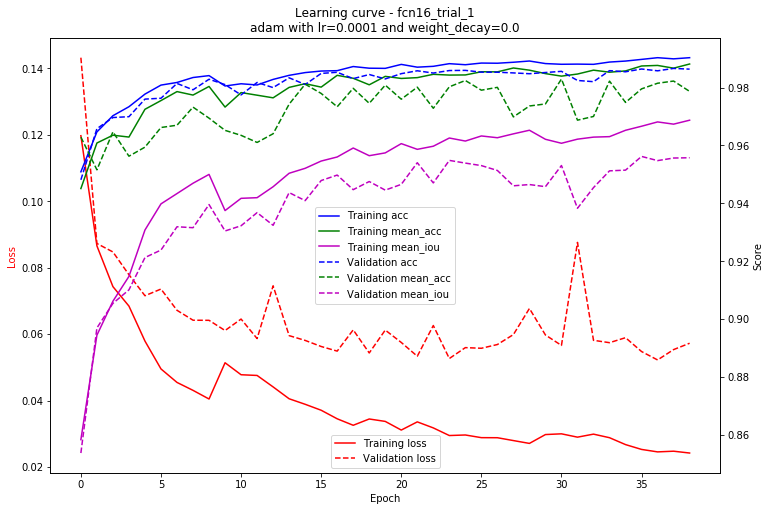

In [28]:
FLAGS.n_epochs = 40
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_1')

<b>One-off FCN8 training</b><br>
<b>Oucome: mIoU 96.2</b>

One-off FCN8 end-to-end training using kitty_road
Building FCN8 for end-to-end training...
Applying fixed learning rate of 0.0001
logits = (?, 3)
labels = (?, 192, 640)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T16:37:37.391842
Epoch 1/80, LR=9.999999747378752e-05
loss = 0.772, acc = 0.815, mean_acc = 0.633, mean_iou = 0.512, val_loss = 0.236, val_acc = 0.887, val_mean_acc = 0.778, val_mean_iou = 0.684
2019-02-08T16:37:53.583422

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.208, acc = 0.908, mean_acc = 0.883, mean_iou = 0.760, val_loss = 0.157, val_acc = 0.935, val_mean_acc = 0.927, val_mean_iou = 0.826
2019-02-08T16:38:05.309634

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.121, acc = 0.950, mean_acc = 0.943, mean_iou = 0.859, val_loss = 0.099, val_acc = 0.958, val_mean_acc = 0.938, val_mean_iou = 0.873
2019-02-08T16:38:17.046411

Epoch 4/80, LR=9.999999747378752e-05
loss = 0.098, acc = 0.959, mean_acc = 0.952, mean_iou = 0.879, val_loss = 0.105, val_acc = 0.9

2019-02-08T16:54:28.585130
Saving learning curve
Saving model checkpoint

Epoch 76/80, LR=9.999999747378752e-05
loss = 0.019, acc = 0.992, mean_acc = 0.990, mean_iou = 0.975, val_loss = 0.057, val_acc = 0.987, val_mean_acc = 0.984, val_mean_iou = 0.960
2019-02-08T16:54:45.488380

Epoch 77/80, LR=9.999999747378752e-05
loss = 0.018, acc = 0.993, mean_acc = 0.991, mean_iou = 0.976, val_loss = 0.058, val_acc = 0.987, val_mean_acc = 0.982, val_mean_iou = 0.959
2019-02-08T16:54:57.404046
Saving model checkpoint

Epoch 78/80, LR=9.999999747378752e-05
loss = 0.018, acc = 0.992, mean_acc = 0.991, mean_iou = 0.976, val_loss = 0.054, val_acc = 0.988, val_mean_acc = 0.983, val_mean_iou = 0.962
2019-02-08T16:55:14.566159

Epoch 79/80, LR=9.999999747378752e-05
loss = 0.018, acc = 0.992, mean_acc = 0.990, mean_iou = 0.976, val_loss = 0.057, val_acc = 0.987, val_mean_acc = 0.981, val_mean_iou = 0.960
2019-02-08T16:55:26.460388

Epoch 80/80, LR=9.999999747378752e-05
loss = 0.017, acc = 0.993, mean_acc 

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

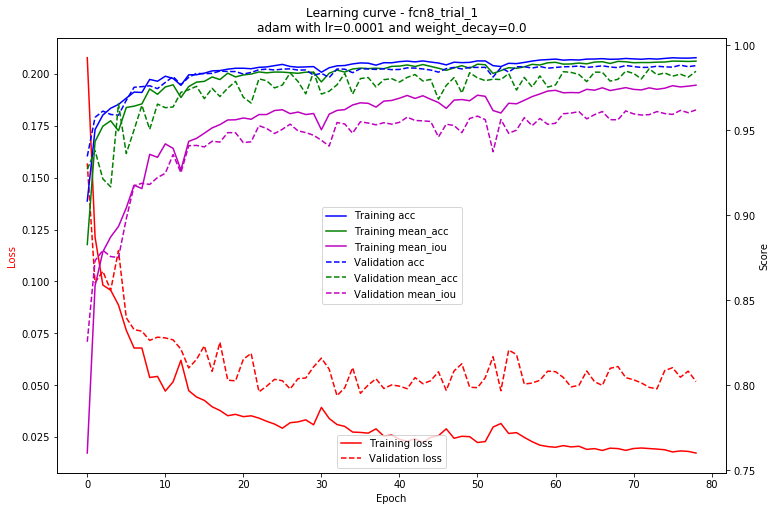

In [29]:
FLAGS.n_epochs = 80
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, ['acc', 'mean_acc', 'mean_iou'], 'fcn8_trial_1')

<b>Staged FCN16 training</b> using pre-trained weights from FCN32<br>
<b>Outcome: mIoU 96.0</b>

One-off FCN16 end-to-end training using kitty_road
Building FCN16 for end-to-end training...
Restoring FCN32 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/kitty_road\fcn32_trial_1-40
Applying fixed learning rate of 0.0001
logits = (?, 3)
labels = (?, 192, 640)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T18:16:05.628575
Epoch 1/80, LR=9.999999747378752e-05
loss = 0.285, acc = 0.896, mean_acc = 0.796, mean_iou = 0.707, val_loss = 0.119, val_acc = 0.950, val_mean_acc = 0.946, val_mean_iou = 0.855
2019-02-08T18:16:21.670373

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.100, acc = 0.960, mean_acc = 0.958, mean_iou = 0.885, val_loss = 0.088, val_acc = 0.962, val_mean_acc = 0.943, val_mean_iou = 0.888
2019-02-08T18:16:33.402976

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.074, acc = 0.970, mean_acc = 0.963, mean_iou = 0.909, val_loss = 0.079, val_acc = 0.970, val_mean_acc = 0.952, val_mean_iou = 0.903
2019-02-08

2019-02-08T18:24:41.901971
Saving model checkpoint

Epoch 37/80, LR=9.999999747378752e-05
loss = 0.025, acc = 0.990, mean_acc = 0.988, mean_iou = 0.968, val_loss = 0.059, val_acc = 0.984, val_mean_acc = 0.976, val_mean_iou = 0.951
2019-02-08T18:24:59.696083
Saving model checkpoint

Epoch 38/80, LR=9.999999747378752e-05
loss = 0.024, acc = 0.990, mean_acc = 0.989, mean_iou = 0.969, val_loss = 0.064, val_acc = 0.985, val_mean_acc = 0.971, val_mean_iou = 0.948
2019-02-08T18:25:17.446447
Saving model checkpoint

Epoch 39/80, LR=9.999999747378752e-05
loss = 0.025, acc = 0.990, mean_acc = 0.987, mean_iou = 0.968, val_loss = 0.060, val_acc = 0.986, val_mean_acc = 0.982, val_mean_iou = 0.953
2019-02-08T18:25:35.214362

Epoch 40/80, LR=9.999999747378752e-05
loss = 0.034, acc = 0.987, mean_acc = 0.984, mean_iou = 0.957, val_loss = 0.066, val_acc = 0.981, val_mean_acc = 0.981, val_mean_iou = 0.940
2019-02-08T18:25:46.950879

Epoch 41/80, LR=9.999999747378752e-05
loss = 0.032, acc = 0.987, mean_ac

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

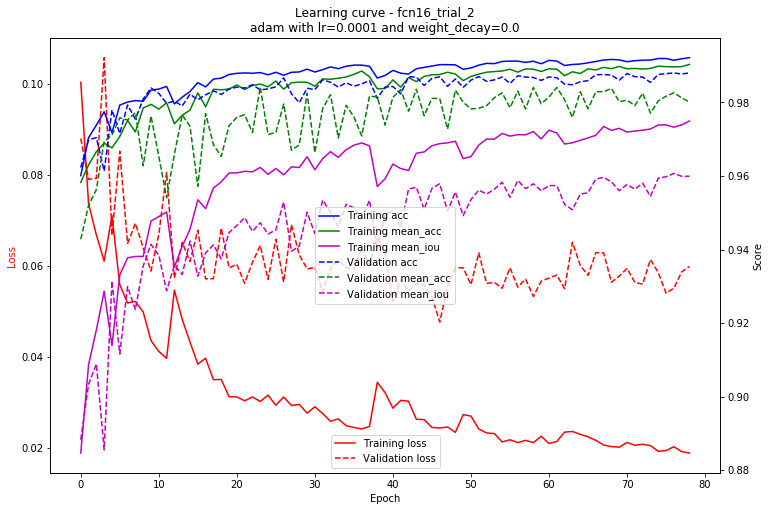

In [15]:
FLAGS.n_epochs = 80
model, datasets = fcn_run_loop.oneoff_training('FCN16', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn16_trial_2', saved_variables='fcn32_trial_1-40')

<b>Staged FCN8 training</b> using pre-trained weights from FCN16<br>
<b>Note:</b> again, staged training is slightly inferior to one-off training for FCN8 (95.3 versus 96.2).

One-off FCN8 end-to-end training using kitty_road
Building FCN8 for end-to-end training...
Restoring FCN16 pre-trained weights...
INFO:tensorflow:Restoring parameters from G:/Datasets/trained_models/tensorflow/kitty_road\fcn16_trial_2-80
Applying fixed learning rate of 0.0001
logits = (?, 3)
labels = (?, 192, 640)
Adam optimizer w/o weight decay
Model build successful
2019-02-08T19:13:34.702136
Epoch 1/80, LR=9.999999747378752e-05
loss = 0.820, acc = 0.809, mean_acc = 0.644, mean_iou = 0.513, val_loss = 0.279, val_acc = 0.846, val_mean_acc = 0.578, val_mean_iou = 0.499
2019-02-08T19:13:50.944948

Epoch 2/80, LR=9.999999747378752e-05
loss = 0.218, acc = 0.899, mean_acc = 0.848, mean_iou = 0.730, val_loss = 0.169, val_acc = 0.927, val_mean_acc = 0.927, val_mean_iou = 0.814
2019-02-08T19:14:02.797755

Epoch 3/80, LR=9.999999747378752e-05
loss = 0.130, acc = 0.943, mean_acc = 0.934, mean_iou = 0.842, val_loss = 0.126, val_acc = 0.948, val_mean_acc = 0.951, val_mean_iou = 0.853
2019-02-08T1

2019-02-08T19:22:00.892298

Epoch 38/80, LR=9.999999747378752e-05
loss = 0.028, acc = 0.989, mean_acc = 0.986, mean_iou = 0.965, val_loss = 0.057, val_acc = 0.985, val_mean_acc = 0.978, val_mean_iou = 0.948
2019-02-08T19:22:12.720018
Saving model checkpoint

Epoch 39/80, LR=9.999999747378752e-05
loss = 0.026, acc = 0.990, mean_acc = 0.987, mean_iou = 0.968, val_loss = 0.055, val_acc = 0.986, val_mean_acc = 0.977, val_mean_iou = 0.952
2019-02-08T19:22:29.552305
Saving model checkpoint

Epoch 40/80, LR=9.999999747378752e-05
loss = 0.027, acc = 0.989, mean_acc = 0.986, mean_iou = 0.966, val_loss = 0.056, val_acc = 0.986, val_mean_acc = 0.981, val_mean_iou = 0.953
2019-02-08T19:22:46.021238

Epoch 41/80, LR=9.999999747378752e-05
loss = 0.027, acc = 0.989, mean_acc = 0.987, mean_iou = 0.966, val_loss = 0.056, val_acc = 0.985, val_mean_acc = 0.978, val_mean_iou = 0.953
2019-02-08T19:22:57.813704

Epoch 42/80, LR=9.999999747378752e-05
loss = 0.025, acc = 0.990, mean_acc = 0.987, mean_iou = 0.

<Figure size 432x288 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

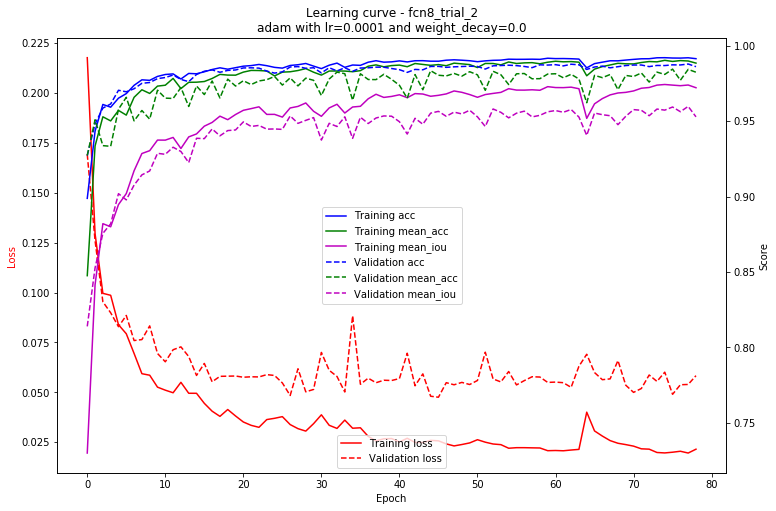

In [18]:
FLAGS.n_epochs = 80
model, datasets = fcn_run_loop.oneoff_training('FCN8', DATASET, DATASET_PATH, 
                                               ['acc', 'mean_acc', 'mean_iou'], 
                                               'fcn8_trial_2', saved_variables='fcn16_trial_2-80')

Once you are satisfied with one of your Kitty Road models, you may want to visualize the predictions. The next cell will save images of the test set masked with pixel-level semantic predictions. A new folder is created each time. Also remember that since the validation set is unlabelled, the test set was created by spliting 20% of the images from the training set. 

In [5]:
from kitty_road_dataset import KittyRoadDataset
dataset = KittyRoadDataset(AUGMENTATION_PARAMS)
dataset.predict_dataset(PREDICTIONS_PATH, os.path.join(DATASET_PATH, 'training/TFRecords', 'segmentation_test.tfrecords'), 
                        model, FLAGS.batch_size)

Saving predictions to G:/Datasets/data_road/predictions/2019-02-15T20H06
